# Behavioral Cloning For Self Driving Cars

Let's train a neural network to drive a car autonomously in a simulator. I'm using sample data consisting of 24k images provided by Udacity for this project. We will be using various data augmentation techniques to improve Neural Network model accuracy.

## Project Goal

No tire of car may leave the drivable portion of the track surface. The car may not pop up onto ledges or roll over any surfaces that would otherwise be considered unsafe (if humans were in the vehicle).

### Data Exploration

Lets see how our data looks like and how its distributed

In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

# driving_log.csv file consists of list of sample images and driving data collected in simulator.
# Each line in the file is tuple of center,left,right,steering,throttle,brake,speed
# center,left and right are the file paths of images taken three different cameras mounted on front of the car.
with open('data/driving_log.csv') as csvfile:
        scene_data = pd.read_csv(csvfile)
center_images = scene_data.center
left_images = scene_data.left
right_images = scene_data.right
steering_data = scene_data.steering
print("Number of center images: ", len(scene_data.center)) #8036


Number of center images:  8036


At every moment during the training three images are shot. That's why total number of sample images available for training is 24k+ (~ 3 * 8036).

Lets see how images captured from those cameras look like:

Image shape:  (160, 320, 3)


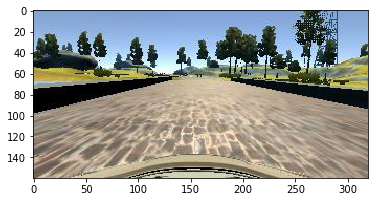

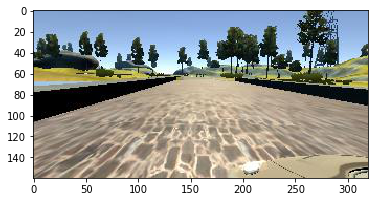

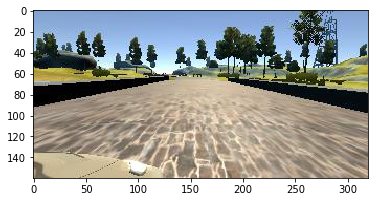

In [2]:
image_center = mpimg.imread('data/IMG/' + center_images[0].split('/')[-1]) # Image from center camera
image_left = mpimg.imread('data/IMG/' + left_images[0].split('/')[-1]) # Image from left camera
image_right = mpimg.imread('data/IMG/' + right_images[0].split('/')[-1]) # Image from right camera

print("Image shape: ", image_center.shape) # (160, 320, 3)
plt.imshow(image_center)
plt.show()
plt.imshow(image_left)
plt.show()
plt.imshow(image_right)
plt.show()

For this project, we use only steering angle to mimic human driving.

In [3]:
print("Steering Angle for 100th image: ", steering_data[99])
steering_data.describe()

Steering Angle for 100th image:  -0.05975719


count    8036.000000
mean        0.004070
std         0.128840
min        -0.942695
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: steering, dtype: float64

Lets visualize steering data on a histogram.

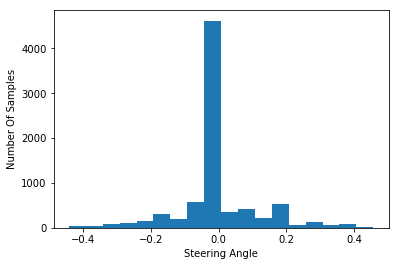

1775
4361
1900


In [4]:
import math
bins = np.arange(min(steering_data) + 0.5, max(steering_data) - 0.5, 0.05)
plt.hist(steering_data, bins=bins)
plt.xlabel('Steering Angle')
plt.ylabel('Number Of Samples')

plt.show()

print(steering_data[steering_data < 0.0 ].count()) #1775
print(steering_data[steering_data == 0.0 ].count()) #4361
print(steering_data[steering_data > 0.0 ].count()) #1900

Oh ah, that doesn't look good ;) Seems like most of the samples have steering angle as ZERO! which makes sense because most the track 1 is simply going straight.

### Model
We will be using exact model used by NVidia team to train the Neural Network

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Lambda, Cropping2D, ELU, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam

act_func = 'relu'
CROP_SHAPE = ((75,25),(0,0))
INPUT_SHAPE = (160, 320, 3)

def nn():
    model = Sequential()

    # Crop the top and bottom part of the image because part of the images with sky and rear end of car 
    # is not really useful for training.
    model.add(Cropping2D(CROP_SHAPE, input_shape=INPUT_SHAPE)) # (60, 320, 3) output shape

    # Resize
    model.add(AveragePooling2D(pool_size=(1,4), trainable=False)) # (60, 80, 3) output shape

    # Normalize
    model.add(Lambda(lambda x: x/127.5 - 1.))

    model.add(Convolution2D(24, 3, 3, subsample=(2,2), activation=act_func))
    model.add(MaxPooling2D())
    model.add(Convolution2D(36, 3, 3, subsample=(1,1), activation=act_func))
    model.add(MaxPooling2D())
    model.add(Convolution2D(48, 3, 3, subsample=(1,1), activation=act_func))
    model.add(MaxPooling2D())

    # Dropout layer
    model.add(Dropout(0.1))

    model.add(Flatten())
    # Fully connected layers layers
    model.add(Dense(100, activation=act_func))
    model.add(Dense(50, activation=act_func))
    model.add(Dense(10, activation=act_func))

    # Node for outputting steering angle
    model.add(Dense(1, trainable=False))
    return model

nn().summary()

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 60, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
averagepooling2d_1 (AveragePooli (None, 60, 80, 3)     0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 60, 80, 3)     0           averagepooling2d_1[0][0]         
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 29, 39, 24)    672         lambda_1[0][0]                   
___________________________________________________________________________________________

### Data Augmentation
Images can be manipulated, transformed and augmented to generate fake data from the seed sample data, which saves us time from generating training data that actually improves model accuracy.

Training data is generated when the car was driven in anti-clockwise direction on the track. So, if the model is trained the initial sampled data, car tends to move left. So, we augmented the training data, by flipping the images horizontally at the center.



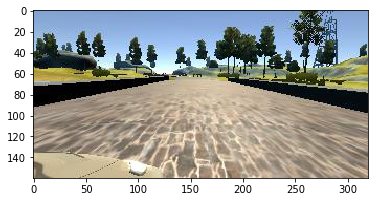

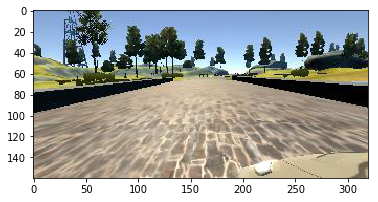

In [6]:
def flip(image):
    return cv2.flip(image, 1)

plt.imshow(image_right)
plt.show()
plt.imshow(flip(image_right))
plt.show()

### Go Generators
Generators can be a great way to work with large amounts of data. Instead of storing the preprocessed data in memory all at once, using a generator you can pull pieces of the data and process them on the fly only when you need them, which is much more memory-efficient.


In [9]:
BATCH_SIZE = 64
CORRECTION = 0.25

def random_samples(data):
    indices = np.random.randint(0, len(data), BATCH_SIZE)
    image_steering_tuples = []

    for index in indices:
        camera_option = np.random.randint(3)
        if camera_option == 0:
            steering_angle = data.iloc[index]['steering']
            image_steering_tuples.append((data.iloc[index]['center'], steering_angle))
        elif camera_option == 1:
            steering_angle = data.iloc[index]['steering'] + CORRECTION
            image_steering_tuples.append((data.iloc[index]['left'], steering_angle))
        else:
            steering_angle = data.iloc[index]['steering'] - CORRECTION
            image_steering_tuples.append((data.iloc[index]['right'], steering_angle))
    return image_steering_tuples

def transform(image, steering_angle):
    if np.random.rand() <= 0.5:
        return flip(image), -1*steering_angle
    return image, steering_angle

def generator(data):
    while True:
        X_batch = []
        y_batch = []
        image_steering_tuples = random_samples(data)
        for path, steering_angle in image_steering_tuples:
            image = mpimg.imread('data/IMG/' + path.split('/')[-1])
            transformed_image, transformed_angle = transform(image, steering_angle)
            X_batch.append(transformed_image)
            y_batch.append(transformed_angle)

        yield np.array(X_batch), np.array(y_batch)

### Run Model
It's time to train the model

In [8]:
mask = np.random.rand(len(scene_data)) <= 0.9

train_samples = scene_data[mask]
validation_samples = scene_data[~mask]

train_data_generator = generator(train_samples)
validation_data_generator = generator(validation_samples)

model = nn()
number_of_samples_per_epoch = 20032
number_of_validation_samples = 6400
LEARNING_RATE = 0.0001

model.compile(optimizer=Adam(LEARNING_RATE), loss="mse")
model.fit_generator(train_data_generator, validation_data=validation_data_generator,
                    samples_per_epoch=number_of_samples_per_epoch, nb_epoch=5, nb_val_samples=len(validation_samples))

with open('model.json', 'w') as outfile:
    outfile.write(model.to_json())
model.save_weights('model.h5')

Epoch 1/5
20032/20032 [==============================] - 43s - loss: 0.0355 - val_loss: 0.0234
Epoch 2/5
20032/20032 [==============================] - 42s - loss: 0.0264 - val_loss: 0.0262
Epoch 3/5
20032/20032 [==============================] - 42s - loss: 0.0252 - val_loss: 0.0223
Epoch 4/5
20032/20032 [==============================] - 42s - loss: 0.0239 - val_loss: 0.0240
Epoch 5/5
20032/20032 [==============================] - 42s - loss: 0.0228 - val_loss: 0.0217
